# Clothing Trade Network Creation

## Reading in and cleaning data

In [66]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [67]:
df = pd.read_csv("trade_data_2000s.csv", index_col=0)

In [68]:
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
945000,3,6,1352,2003.0,0.0,4281.0,1.535351,0.268432,AIA,ANT,8423
945001,25,6,1352,2003.0,0.0,26220.0,0.308971,-0.561269,BHS,ANT,8423
945002,29,6,1352,2003.0,0.0,84921.0,-0.546138,-0.787781,BLZ,ANT,8423
945003,32,6,1352,2003.0,8011.0,0.0,0.636739,1.422593,BRA,ANT,8423
945004,33,6,1352,2003.0,0.0,2387.0,0.499073,-0.065065,BRB,ANT,8423
...,...,...,...,...,...,...,...,...,...,...,...
3982467,166,242,1363,2019.0,2379.0,0.0,0.099708,0.079208,NZL,WSM,8443
3982468,127,210,1363,2019.0,0.0,2392.0,0.263772,-0.709830,LCA,SXM,8443
3982469,231,210,1363,2019.0,11067.0,0.0,1.528196,0.297825,USA,SXM,8443
3982470,77,27,1363,2019.0,1706.0,0.0,1.345057,1.075400,FRA,BLM,8443


In [69]:
#grouping data by countries and year and taking sum so we just get total export and import values across all goods
df_grouped = df.groupby(['location_id', 'partner_id','year']).sum().reset_index()

In [70]:
#removing unnecessary columns
df_grouped_first = df_grouped.drop(['sitc_eci', 'sitc_coi','location_code','partner_code','sitc_product_code'], axis=1)
df_grouped_second = df_grouped_first.copy()

In [71]:
df_grouped_first

,location_id,partner_id,year,product_id,export_value,import_value
0,0,6,2005.0,31389,860510.0,3276527.0
1,0,6,2006.0,30017,1027015.0,96392.0
2,0,6,2007.0,30006,1014011.0,257016.0
3,0,6,2008.0,27280,1216843.0,103197.0
4,0,6,2009.0,34065,124191.0,3156666.0
...,...,...,...,...,...,...
388479,250,249,2014.0,32736,1921886.0,247429.0
388480,250,249,2015.0,32730,1593013.0,195494.0
388481,250,249,2016.0,30021,2281034.0,1948209.0
388482,250,249,2017.0,31346,1438130.0,1628499.0


In [72]:
#merging so that each row shows imports and exports for both countries involved in bilateral trade relationship
new_df = pd.merge(df_grouped_first, df_grouped_second,  how='left', left_on=['location_id','partner_id','year'], right_on = ['partner_id','location_id','year'])

In [73]:
new_df

,location_id_x,partner_id_x,year,product_id_x,export_value_x,import_value_x,location_id_y,partner_id_y,product_id_y,export_value_y,import_value_y
0,0,6,2005.0,31389,860510.0,3276527.0,6,0,31389,3276527.0,860510.0
1,0,6,2006.0,30017,1027015.0,96392.0,6,0,30017,96392.0,1027015.0
2,0,6,2007.0,30006,1014011.0,257016.0,6,0,30006,257016.0,1014011.0
3,0,6,2008.0,27280,1216843.0,103197.0,6,0,27280,103197.0,1216843.0
4,0,6,2009.0,34065,124191.0,3156666.0,6,0,34065,3156666.0,124191.0
...,...,...,...,...,...,...,...,...,...,...,...
388479,250,249,2014.0,32736,1921886.0,247429.0,249,250,32736,247429.0,1921886.0
388480,250,249,2015.0,32730,1593013.0,195494.0,249,250,32730,195494.0,1593013.0
388481,250,249,2016.0,30021,2281034.0,1948209.0,249,250,30021,1948209.0,2281034.0
388482,250,249,2017.0,31346,1438130.0,1628499.0,249,250,31346,1628499.0,1438130.0


In [74]:
#dropping columns and renaming
final_df = new_df.drop(['location_id_y', 'partner_id_y','product_id_y','product_id_x'], axis=1)
final_df = final_df.rename(columns={'location_id_x': 'location_1', 
                                    'partner_id_x': 'location_2',
                                    'export_value_x':'export_ij',
                                    'export_value_y':'export_ji',
                                    'import_value_x':'import_ij',
                                    'import_value_y':'iimport_ji'})

In [75]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0
...,...,...,...,...,...,...,...
388479,250,249,2014.0,1921886.0,247429.0,247429.0,1921886.0
388480,250,249,2015.0,1593013.0,195494.0,195494.0,1593013.0
388481,250,249,2016.0,2281034.0,1948209.0,1948209.0,2281034.0
388482,250,249,2017.0,1438130.0,1628499.0,1628499.0,1438130.0


## Creation of Network

In [76]:
#Edge weight that will be used in creation of network - used in past literature
final_df['edge_value'] = (final_df['export_ij']+final_df['export_ji']+final_df['import_ij']+final_df['iimport_ji'])/2

In [77]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0,4137037.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0,1123407.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0,1271027.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0,1320040.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0,3280857.0
...,...,...,...,...,...,...,...,...
388479,250,249,2014.0,1921886.0,247429.0,247429.0,1921886.0,2169315.0
388480,250,249,2015.0,1593013.0,195494.0,195494.0,1593013.0,1788507.0
388481,250,249,2016.0,2281034.0,1948209.0,1948209.0,2281034.0,4229243.0
388482,250,249,2017.0,1438130.0,1628499.0,1628499.0,1438130.0,3066629.0


In [78]:
def update_graph_with_missing_nodes(graph, nodes):
    missing_nodes = set(nodes) - set(graph.nodes())
    for node in missing_nodes:
        graph.add_node(node)
    return graph

In [79]:
sorted(final_df['year'].unique())

[2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

In [80]:
#Create weighted adjacency matrix for each year
locations = final_df['location_1'].unique()
adj_matrices = []
connected_graphs = []
whole_graphs = []
for i in sorted(final_df['year'].unique()):
    df = final_df[final_df['year']==i]
    edges = pd.DataFrame(
        {
            "source": list(df['location_1']),
            "target": list(df['location_2']),
            "weight": list(df['edge_value'])
        }
    )
    G = nx.from_pandas_edgelist(edges, edge_attr=True)
    connected_graphs.append(G)
    whole_graph = update_graph_with_missing_nodes(G, locations)
    whole_graphs.append(G)

## Distance Metrics

### 1. Hamming Distance

In [81]:
def hamming_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            sum += abs(value_1-value_2)/(N*(N-1))
    
    return sum


In [82]:
hamming_distances = []
for i in range(len(whole_graphs)-1):
    hamming_distances.append(hamming_distance(whole_graphs[i], whole_graphs[i+1]))

### 2. Jaccard Distance

In [83]:
def jaccard_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    absolute = 0
    maximum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            absolute += abs(value_1-value_2)
            maximum += max(value_1,value_2)
        
    sum += absolute/maximum

    return sum

In [84]:
jaccard_distances = []
for i in range(len(whole_graphs)-1):
    jaccard_distances.append(jaccard_distance(whole_graphs[i], whole_graphs[i+1]))

### 3. Spanning Tree Dissimilarity

In [85]:
#Calculate the spanning tree number for each graph
def spanning_tree(G):
    eigenvalues = nx.normalized_laplacian_spectrum(G)
    nonzero_eig = eigenvalues[np.nonzero(eigenvalues)]
    N = len(nonzero_eig)
    
    product = 1
    for e in range(1,len(nonzero_eig)):
        product = product * nonzero_eig[e]

    return (1/N)*product

In [86]:
#Calculate the distance between each graph
st_distances = []
for i in range(len(connected_graphs)-1):
    st_1 = spanning_tree(connected_graphs[i])
    st_2 = spanning_tree(connected_graphs[i+1])
    st_distances.append(abs(math.log(st_1)-math.log(st_2)))

### 4. Polynomial Distance

In [87]:
#Calculate W
def calculate_w(eigenvalues, k, alpha):
    w = eigenvalues[0]
    n = len(eigenvalues)
    for i in range(2,k+1):
        coef = ((1/(n-1))**(alpha*(i-1)))
        w += coef*(eigenvalues[i-1]**(i))

    return w

In [88]:
#Calculate P
def calculate_p(w, q):
    q_w = np.dot(q,w)
    return np.dot(q_w, q.T)

In [89]:
def polynomial_distance(G1, G2):
    n = len(G1.nodes())

    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    eigvec_1 = np.linalg.eig(t_1)[1]
    eigenvals_1 = nx.laplacian_spectrum(G1)

    eigvec_2 = np.linalg.eig(t_2)[1]
    eigenvals_2 = nx.laplacian_spectrum(G2)

    t1_w = calculate_w(eigenvals_1, 5, 1)
    t2_w = calculate_w(eigenvals_2, 5, 1)

    t1_p = calculate_p(t1_w, eigvec_1)
    t2_p = calculate_p(t2_w, eigvec_2)

    return (1/n**2)*np.linalg.norm(t1_p-t2_p)

        

In [90]:
polynomial_distances = []
for i in range(len(whole_graphs)-1):
    polynomial_distances.append(polynomial_distance(whole_graphs[i], whole_graphs[i+1]))

### Analyzing Distances

In [91]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [92]:
j_norm = normalize([jaccard_distances])
h_norm = normalize([hamming_distances])
st_norm = normalize([st_distances])
p_norm = normalize([polynomial_distances])

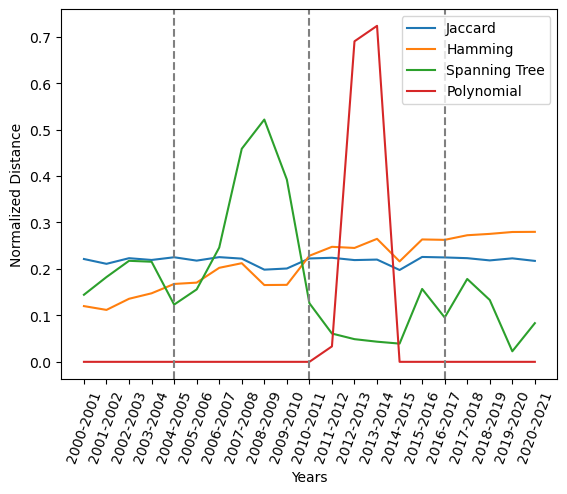

In [102]:
graphs = range(21)
graph_labels = []
years = sorted(final_df['year'].unique())
for i in range(len(years)-1):
    graph_labels.append(f"{int(years[i])}-{int(years[i+1])}")

# Create a line plot
plt.plot(graph_labels, j_norm[0], label="Jaccard")
plt.plot(graph_labels, h_norm[0], label="Hamming")
plt.plot(graph_labels, st_norm[0], label="Spanning Tree")
plt.plot(graph_labels, p_norm[0], label="Polynomial")

plt.axvline(x = "2004-2005", color = 'grey', ls='--')
plt.axvline(x = "2010-2011", color = 'grey', ls='--')
plt.axvline(x = "2016-2017", color = 'grey', ls='--')

# Show the plot
plt.xlabel("Years")
plt.ylabel("Normalized Distance")
plt.xticks(rotation=70)
plt.legend()
plt.show()

In [137]:
j_points=np.array(jaccard_distances)
h_points=np.array(hamming_distances)
st_points=np.array(st_distances)
p_points=np.array(polynomial_distances)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


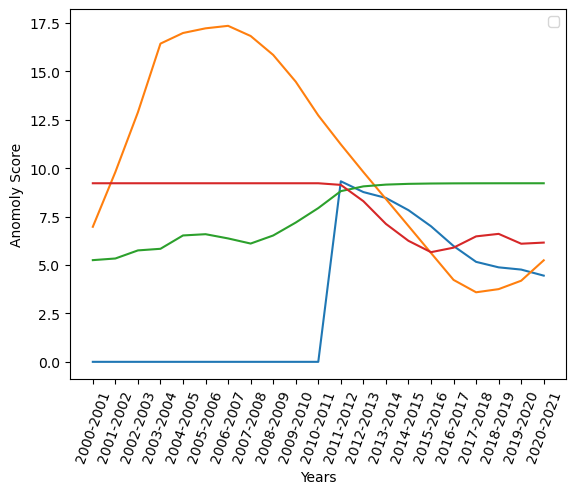

In [142]:
import changefinder
#Initiate changefinder function
cf = changefinder.ChangeFinder()
j_scores = [cf.update(p) for p in j_points]
h_scores = [cf.update(p) for p in h_points]
st_scores = [cf.update(p) for p in st_points]
p_scores = [cf.update(p) for p in p_points]
plt.plot(graph_labels, j_scores)
plt.plot(graph_labels, h_scores)
plt.plot(graph_labels, st_scores)
plt.plot(graph_labels, p_scores)

plt.xlabel("Years")
plt.ylabel("Anomoly Score")
plt.xticks(rotation=70)
plt.legend()
plt.show()


In [143]:
!pip install ruptures

  Obtaining dependency information for ruptures from https://files.pythonhosted.org/packages/15/a6/9a5f62af2767d86bcc33c746bf421e602351ceee3b57e7b785f9601e5a38/ruptures-1.1.9-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 2.3 MB/s eta 0:00:00a 0:00:01


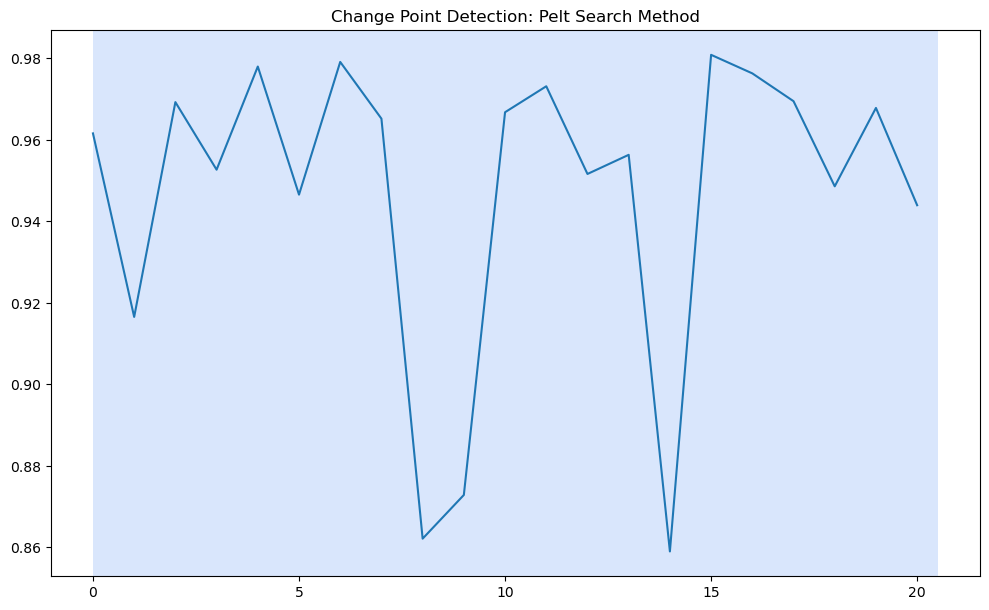

In [147]:
import ruptures as rpt
model="rbf"
algo = rpt.Pelt(model=model).fit(j_points)
result = algo.predict(pen=3)
rpt.display(j_points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

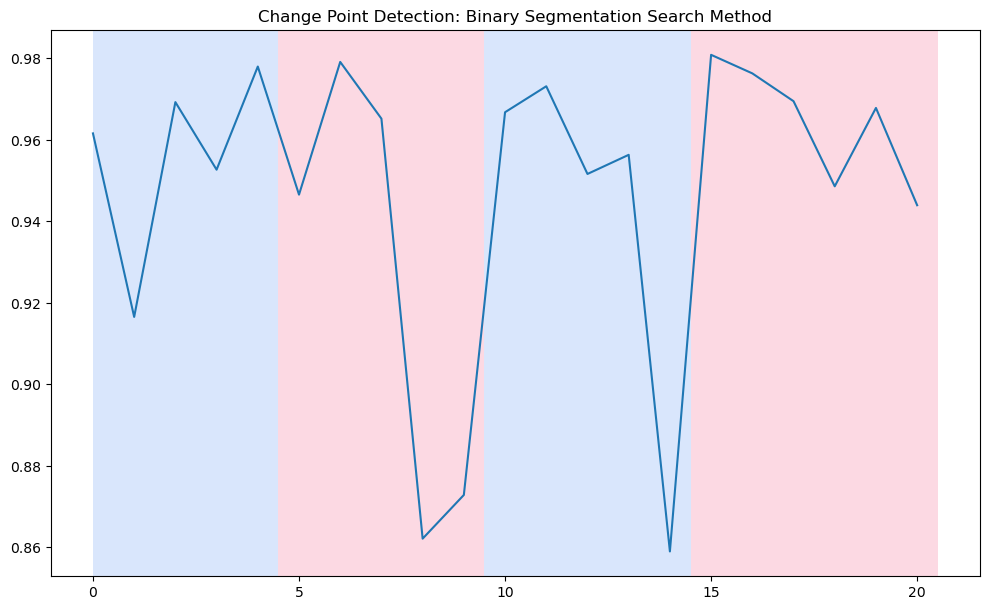

In [146]:
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(j_points)
my_bkps = algo.predict(n_bkps=3)
# show results
rpt.show.display(j_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()


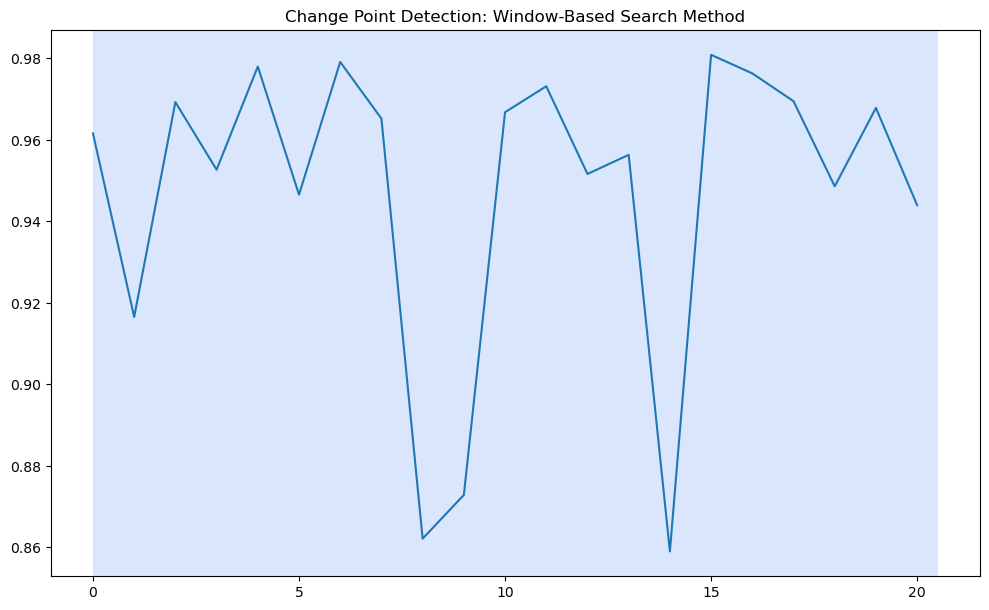

In [148]:
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(j_points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(j_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()
    

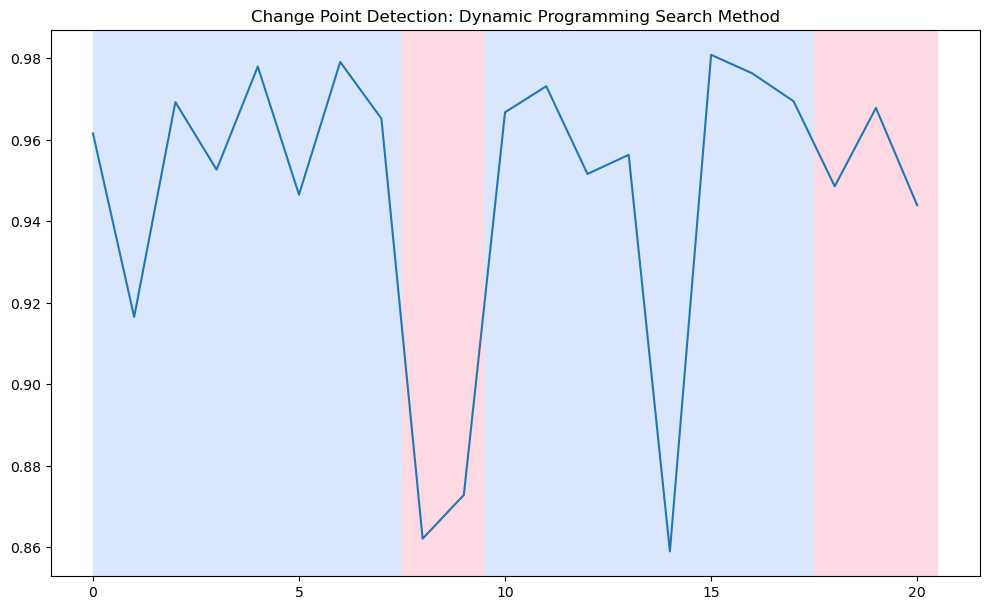

In [165]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=1, jump=1).fit(j_points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(j_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

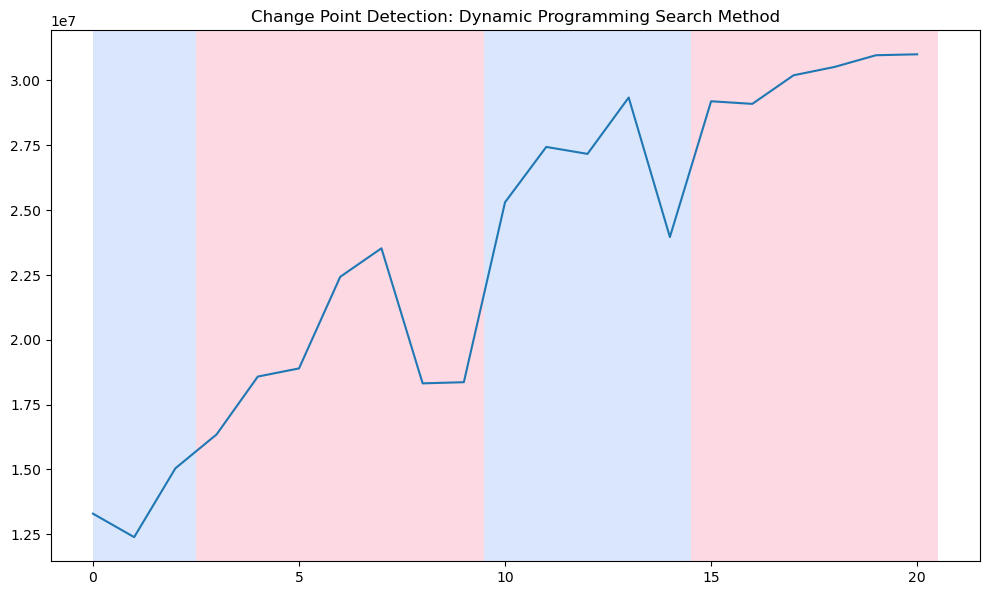

In [164]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=1, jump=1).fit(h_points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(h_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

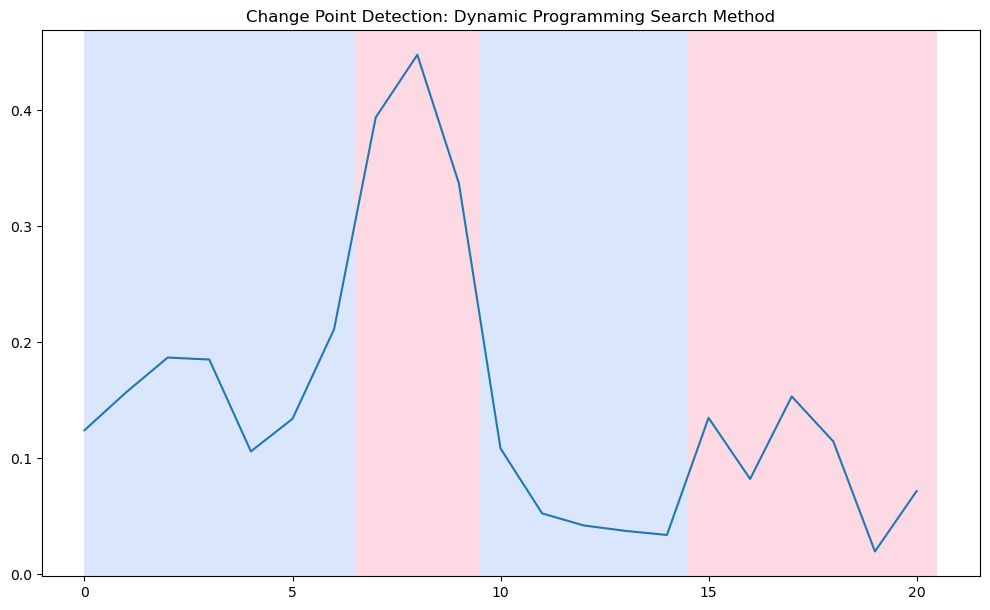

In [163]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=1, jump=1).fit(st_points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(st_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

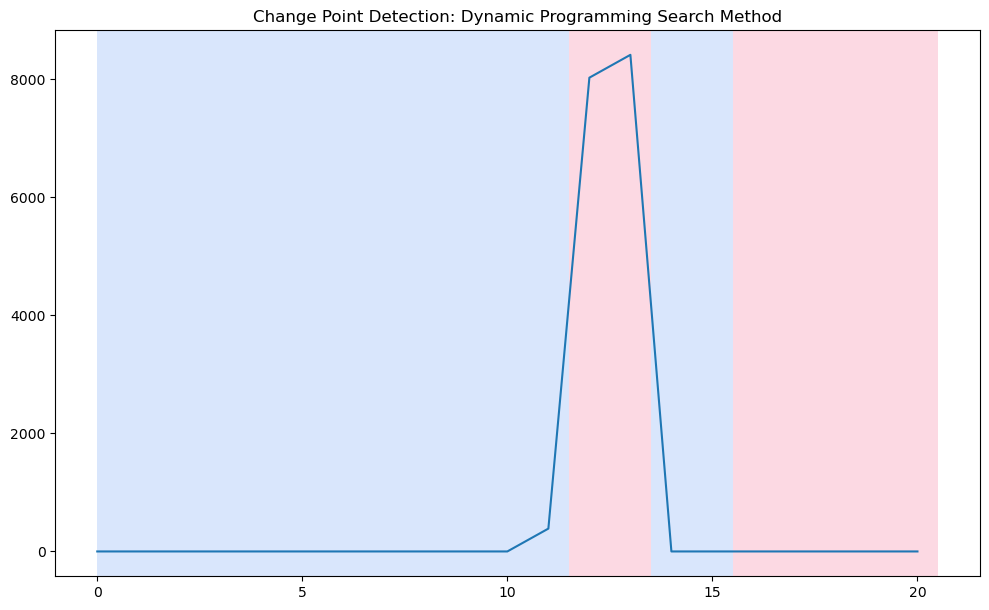

In [162]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=1, jump=1).fit(p_points)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(p_points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()